# Probabilistic Modeling with Timing and Different Keras Backends

**WORK IN PROGRESS Only TFP WORKING CURRENTLY**

This notebook demonstrates how to implement probabilistic modeling in neural networks using Keras
with three different backends: **PyTorch**, **JAX**, and **TensorFlow**. Each model outputs the parameters 
of a normal distribution (mean and variance) and optimizes the Negative Log-Likelihood (NLL) as the loss.

### Features:
- Maintain the simplicity of the Keras API.
- Use a probabilistic output with sampling, CDF, and PDF.
- Compare the three backends for flexibility, performance, and distribution support.
- Include timing for training.

## 1. Generate and Visualize Training Data

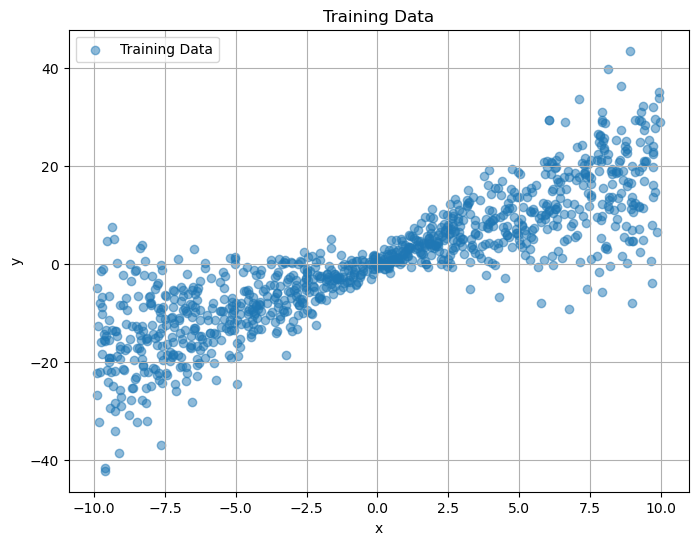

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
np.random.seed(42)
x_train = np.random.uniform(-10, 10, (1000, 1)).astype(np.float32)
y_train = (2 * x_train + np.random.normal(0, np.abs(x_train) + 1, (1000, 1))).astype(np.float32)

# Plot training data
plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, alpha=0.5, label="Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training Data")
plt.legend()
plt.grid()
plt.show()

## 2. PyTorch Backend with `torch.distributions`

In [4]:
import os
os.environ["KERAS_BACKEND"] = "torch" # set backend before importing keras 

import keras
import keras.backend as K
backend_name = K.backend()
print("Aktuell verwendetes Backend:", backend_name)

import torch
import torch.distributions as dist
import time

# Custom Distribution Layer
class DistributionLayer(keras.layers.Layer):
    def call(self, inputs):
        mean, log_variance = inputs[:, 0], inputs[:, 1]
        variance = torch.exp(log_variance)  # Ensure positive variance
        return dist.Normal(mean, torch.sqrt(variance))  # Return a PyTorch distribution object

# Define the model
inputs = keras.Input(shape=(1,), dtype=torch.float32)
hidden = keras.layers.Dense(10, activation="relu")(inputs)
# Here, you can add a deeper or larger Keras network if needed
mean_output = keras.layers.Dense(1)(hidden)
log_variance_output = keras.layers.Dense(1)(hidden)
outputs = keras.layers.Concatenate()([mean_output, log_variance_output])

# Add the custom distribution layer
distribution_output = DistributionLayer()(outputs)

# Define the Keras model
model = keras.Model(inputs=inputs, outputs=distribution_output)

# Custom Negative Log-Likelihood Loss
def negative_log_likelihood(y_true, distribution):
    return -distribution.log_prob(y_true).mean()  # Negative log-likelihood

# Compile the model
model.compile(optimizer="adam", loss=negative_log_likelihood)

# Train the model and measure timing
start_time = time.time()
model.fit(x_train, y_train, epochs=100, batch_size=32)
pytorch_training_time = time.time() - start_time

print(f"PyTorch Training Time: {pytorch_training_time:.2f} seconds")

# Predict the distribution
x_test = torch.tensor(np.linspace(-10, 10, 100).reshape(-1, 1).astype(np.float32))
predicted_distribution = model(x_test)

# Use the distribution
samples = predicted_distribution.sample((5,))  # Draw 5 samples
cdf_values = predicted_distribution.cdf(torch.tensor([0.0]))  # CDF at y = 0
print("PyTorch Samples:", samples)
print("PyTorch CDF Values:", cdf_values)


Aktuell verwendetes Backend: torch


AttributeError: Exception encountered when calling DistributionLayer.call().

[1mCould not automatically infer the output shape / dtype of 'distribution_layer' (of type DistributionLayer). Either the `DistributionLayer.call()` method is incorrect, or you need to implement the `DistributionLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

'Normal' object has no attribute 'shape'[0m

Arguments received by DistributionLayer.call():
  • args=('<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_4>',)
  • kwargs=<class 'inspect._empty'>

## 3. JAX Backend with NumPyro

In [5]:
import os
import jax 
print(jax.__version__)
os.environ["KERAS_BACKEND"] = "jax" # set backend before importing keras 

import numpyro
print(numpyro.__version__)

import keras
import jax.numpy as jnp
from jax import random
from numpyro import distributions as dist
import time

# Set JAX as the backend
#keras.backend.set_backend("jax")

# Custom Distribution Layer
class DistributionLayer(keras.layers.Layer):
    def call(self, inputs):
        mean, log_variance = inputs[:, 0], inputs[:, 1]
        variance = jnp.exp(log_variance)  # Ensure positive variance

        # Create the NumPyro Normal distribution
        distribution = dist.Normal(mean, jnp.sqrt(variance))

        # Sample from the distribution
        sampled_values = distribution.sample(random.PRNGKey(0))

        # Return both the sample and the distribution
        return {"sample": sampled_values, "distribution": distribution}

# Define the model
inputs = keras.Input(shape=(1,), dtype=np.float32)
hidden = keras.layers.Dense(10, activation="relu")(inputs)
# Here, you can add a deeper or larger Keras network if needed
mean_output = keras.layers.Dense(1)(hidden)
log_variance_output = keras.layers.Dense(1)(hidden)
outputs = keras.layers.Concatenate()([mean_output, log_variance_output])

# Add the custom distribution layer
distribution_layer = DistributionLayer()
distribution_output = distribution_layer(outputs)

# Define the Keras model
model = keras.Model(inputs=inputs, outputs=distribution_output)

# Custom Negative Log-Likelihood Loss
def negative_log_likelihood(y_true, output):
    distribution = output["distribution"]
    return -jnp.mean(distribution.log_prob(y_true))  # Negative log-likelihood

# Compile the model
model.compile(optimizer="adam", loss=negative_log_likelihood)

# Train the model and measure timing
start_time = time.time()
model.fit(x_train, y_train, epochs=100, batch_size=32)
jax_training_time = time.time() - start_time

print(f"JAX Training Time: {jax_training_time:.2f} seconds")

# Predict the distribution
x_test = jnp.linspace(-10, 10, 100).reshape(-1, 1)
predicted_distribution = model(x_test)

# Use the distribution
samples = predicted_distribution.sample(random.PRNGKey(0), (5,))  # Draw 5 samples
cdf_values = predicted_distribution.cdf(0.0)  # CDF at y = 0
print("JAX Samples:", samples)
print("JAX CDF Values:", cdf_values)


0.4.26
0.15.3


ValueError: Exception encountered when calling DistributionLayer.call().

[1mAll operation outputs must be tensors. Operation <DistributionLayer name=distribution_layer_1, built=True> returned a non-tensor. Non-tensor received: <numpyro.distributions.continuous.Normal object at 0x16aa985b0>[0m

Arguments received by DistributionLayer.call():
  • args=('<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_9>',)
  • kwargs=<class 'inspect._empty'>

## 4. TensorFlow Backend with TensorFlow Probability

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import time

tfd = tfp.distributions

# Define the model
inputs = tf.keras.Input(shape=(1,))
hidden = tf.keras.layers.Dense(10, activation="relu")(inputs)
# Here, you can add a deeper or larger Keras network if needed
mean = tf.keras.layers.Dense(1)(hidden)
log_variance = tf.keras.layers.Dense(1)(hidden)
distribution = tfp.layers.DistributionLambda(
    lambda params: tfd.Normal(loc=params[:, 0:1], scale=tf.exp(params[:, 1:2]))
)(tf.concat([mean, log_variance], axis=-1))

model = tf.keras.Model(inputs, distribution)

# Custom Loss Function
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile the model
model.compile(optimizer="adam", loss=negative_log_likelihood)

# Train the model and measure timing
start_time = time.time()
model.fit(x_train, y_train, epochs=100, batch_size=32)
tensorflow_training_time = time.time() - start_time

print(f"TensorFlow Training Time: {tensorflow_training_time:.2f} seconds")

# Predict the distribution
x_test = np.linspace(-10, 10, 100).reshape(-1, 1).astype(np.float32)
predicted_distribution = model(x_test)

# Use the distribution
samples = predicted_distribution.sample(5)  # Draw 5 samples
cdf_values = predicted_distribution.cdf(0.0)  # CDF at y = 0
print("TFP Samples:", samples)
print("TFP CDF Values:", cdf_values)


AttributeError: module 'keras._tf_keras.keras' has no attribute '__internal__'

## 5. Comparison of Timing and Features

In [ ]:
from tabulate import tabulate

# Timing results
results = [
    ["PyTorch", f"{pytorch_training_time:.2f} seconds", "Good", "Medium"],
    ["JAX", f"{jax_training_time:.2f} seconds", "Excellent", "High"],
    ["TensorFlow", f"{tensorflow_training_time:.2f} seconds", "Excellent", "Medium"],
]

# Table headers
headers = ["Framework", "Training Time", "Distribution Support", "Performance"]

# Print table
print(tabulate(results, headers=headers, tablefmt="grid"))
